# Simple regression with TensorFlow

Progressive example working through various network set ups

https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(42)


2.13.1


In [4]:
from keras import Sequential
from keras import models
from keras import layers

In [5]:
dat = pd.read_csv("./rbfs/phi_short_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,210,211,212,213,214,215,216,y,site,date
0,0,1.000000,0.933712,0.760067,0.539408,0.333740,0.180022,0.084658,0.034709,0.012406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,2005,2023-01-01
1,1,0.999950,0.937113,0.765652,0.545377,0.338679,0.183361,0.086546,0.035614,0.012777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007,2005,2023-01-01
2,2,0.999802,0.940433,0.771202,0.551358,0.343658,0.186743,0.088468,0.036539,0.013157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,2005,2023-01-01
3,3,0.999555,0.943672,0.776715,0.557350,0.348675,0.190169,0.090424,0.037485,0.013547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,2005,2023-01-01
4,4,0.999208,0.946828,0.782189,0.563351,0.353730,0.193638,0.092414,0.038451,0.013948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,2005,2023-01-01


In [6]:
dat.site

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
2664    4002
2665    4002
2666    4002
2667    4002
2668    4002
Name: site, Length: 2669, dtype: int64

In [7]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(191, 221)

In [8]:
dat2 = dat2.groupby('site')

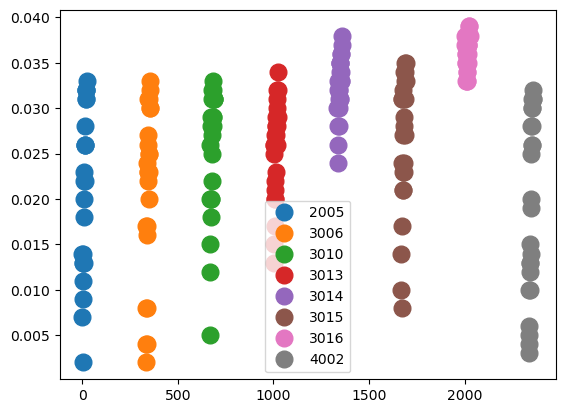

In [9]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [10]:
X = dat.iloc[:, 1:218]
y = dat['y']

In [11]:
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

8

In [12]:
groups

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
2664    4002
2665    4002
2666    4002
2667    4002
2668    4002
Name: site, Length: 2669, dtype: int64

In [13]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [14]:
def make_model(n_feat):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_feat,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')
        ], name="Initial_model")
    return model

In [15]:
model = make_model(100)
model.summary()

Model: "Initial_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 544513 (2.08 MB)
Trainable params: 5445

## Cross-validation loop

In [16]:
# Model set up
initial_learning_rate = 0.00001
optimizer = keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate)
n_epochs = 20
batch_size = 1024

In [17]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [18]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    model = make_model(n_feat)

    # Compile model
    model.compile(loss='mae', metrics=['mae', 'mse'], optimizer=optimizer)

    # Train model
    history=model.fit(X_train, y_train, epochs=n_epochs, 
                  batch_size=batch_size, verbose=1, 
                  validation_split=0.2)
    
    ## Predict for test set
    y_test_pred = model.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test.to_numpy())
    my_y_pred.append(y_test_pred)




Fold 0:
Site 2005:
(2336, 217)
(333, 217)
Epoch 1/20
2/2 [==============================] - 0s 115ms/step - loss: 0.0575 - mae: 0.0575 - mse: 0.0043 - val_loss: 0.0369 - val_mae: 0.0369 - val_mse: 0.0019
Epoch 2/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0480 - mae: 0.0480 - mse: 0.0031 - val_loss: 0.0302 - val_mae: 0.0302 - val_mse: 0.0013
Epoch 3/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0398 - mae: 0.0398 - mse: 0.0023 - val_loss: 0.0253 - val_mae: 0.0253 - val_mse: 9.3442e-04
Epoch 4/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0330 - mae: 0.0330 - mse: 0.0016 - val_loss: 0.0223 - val_mae: 0.0223 - val_mse: 7.4872e-04
Epoch 5/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0277 - mae: 0.0277 - mse: 0.0012 - val_loss: 0.0209 - val_mae: 0.0209 - val_mse: 7.0267e-04
Epoch 6/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0244 - mae: 0.0244 - mse: 9.7485e-04 - val_loss: 0.0214 - val_mae: 

In [19]:
my_y_pred

[array([[-1.24789157e-03],
        [-8.79289059e-04],
        [-2.41768939e-04],
        [ 9.47477092e-05],
        [ 3.82082362e-06],
        [ 1.90361010e-04],
        [ 6.19879516e-04],
        [ 1.07261783e-03],
        [ 1.46727881e-03],
        [ 1.60615018e-03],
        [ 1.30468479e-03],
        [ 9.56746342e-04],
        [ 1.22835732e-03],
        [ 2.11262563e-03],
        [ 3.01982323e-03],
        [ 3.76360724e-03],
        [ 4.94312355e-03],
        [ 6.18074322e-03],
        [ 7.06905732e-03],
        [ 7.70309987e-03],
        [ 8.24437570e-03],
        [ 8.56963266e-03],
        [ 9.62840486e-03],
        [ 1.00431601e-02],
        [ 9.93899908e-03],
        [ 9.84490942e-03],
        [ 9.68286861e-03],
        [ 9.36049130e-03],
        [ 8.83337762e-03],
        [ 8.55944585e-03],
        [ 8.51798151e-03],
        [ 8.67901649e-03],
        [ 8.27249419e-03],
        [ 7.99106900e-03],
        [ 8.73328652e-03],
        [ 8.73589609e-03],
        [ 8.15866422e-03],
 

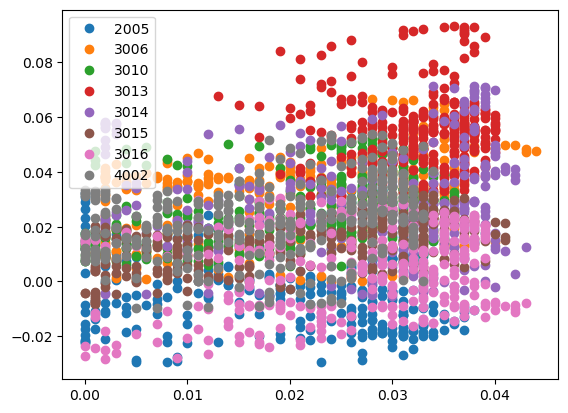

In [20]:
plt.figure()
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()

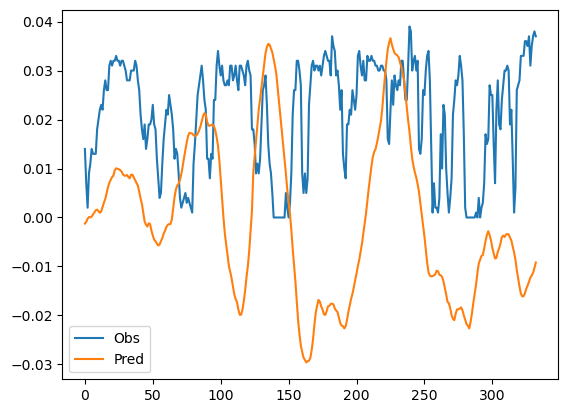

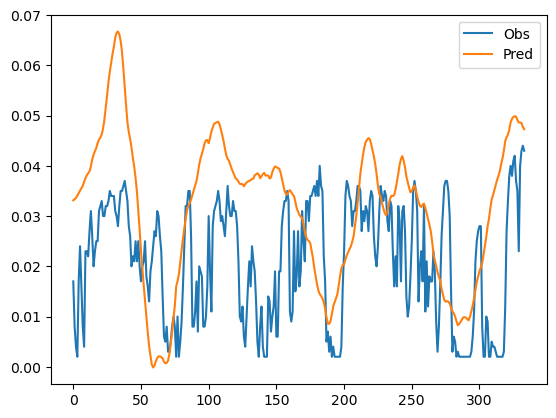

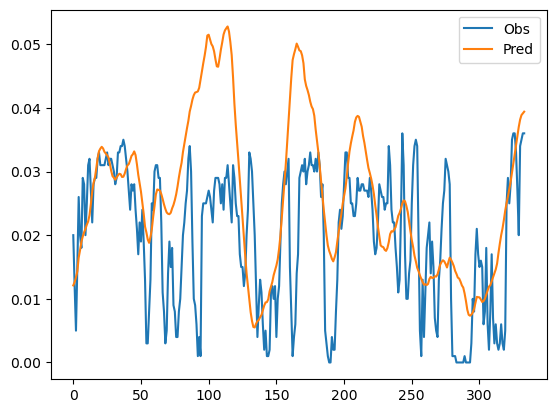

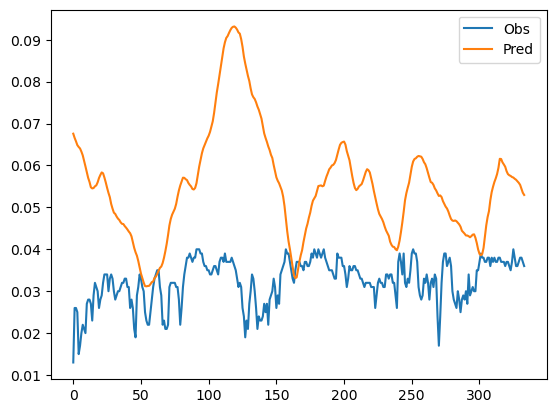

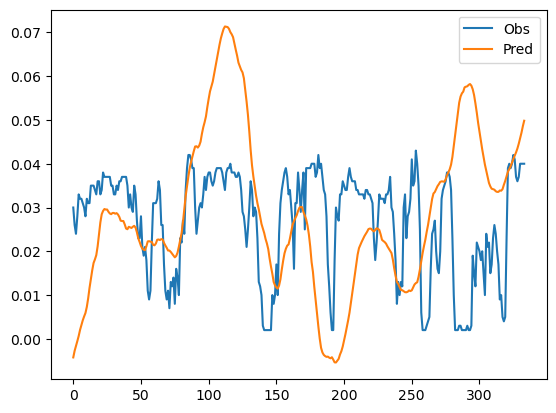

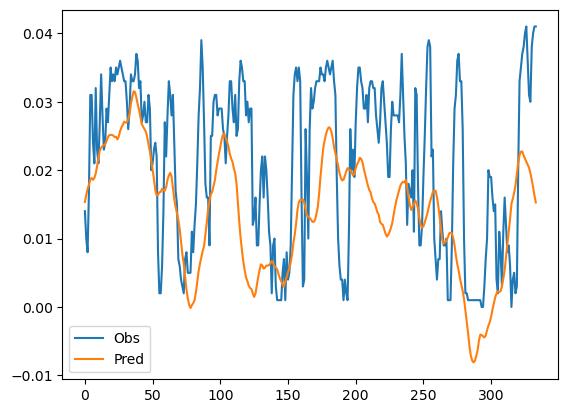

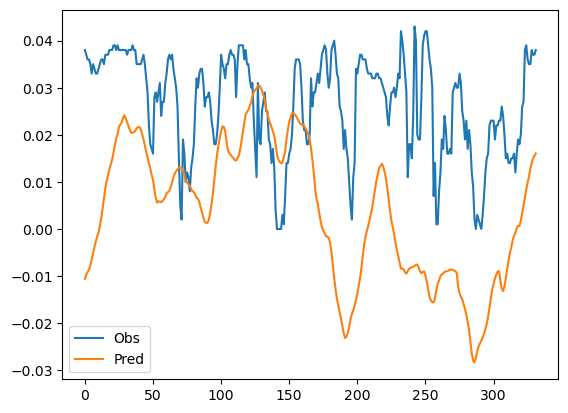

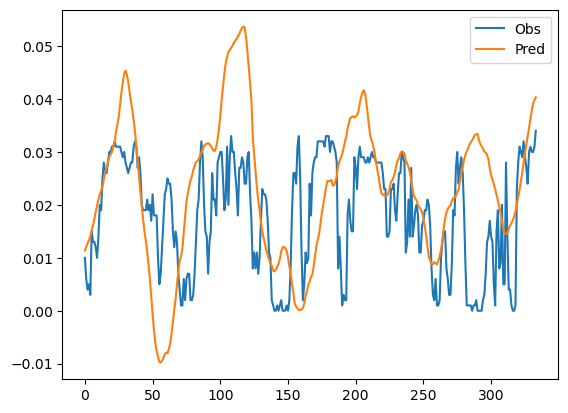

In [21]:
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], label = "Obs")
    plt.plot(my_y_pred[i], label = "Pred")
    plt.legend()
    plt.show()